In [2]:
### Import meta file for Kanungu and Tororo 
import pandas as pd
df_meta = pd.read_excel("Ugandan_samples_metadata.xlsx",header=0,index_col = 'Barcode',engine='openpyxl')

df_meta['agecut'] = '2-3'

def age1(row):
 
    age = row.age
    if ((age >=4) & (age <7)):
        agecut = '4-6'
    elif ((age >=7) & (age <11)):
        agecut = '7-11'
    elif (age >=18):
        agecut = 'adults'
    else:
        agecut = '2-3'
    
    return agecut

df_meta['agecut'] = df_meta.apply(age1,axis=1)
        

In [4]:
## Getting the Z scores of patients and healthys for the 9927 hits to plot 

### Within Kanungu and Tororo, the samples are sorted by age group in ascending order and then descending order of tsi 
import sys
sys.setrecursionlimit(100000)
import pandas as pd 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np 

#### calculating seropositivity of peptides and sorting them from highest to lowest 

hits_5 = pd.read_csv("HITS_Round2_Pfonly_250kfil_techclean_3zscorefil_5patientsfil.csv",header=0,index_col = 'peptide') ##peptide is the index

hits_5patients_Kanungu = hits_5.filter(regex='CK3').T
hits_5patients_Kanungu.index.names = ['Barcode']

hits_5patients_Tororo = hits_5.filter(regex='CT3').T
hits_5patients_Tororo.index.names = ['Barcode']



hits_5patients_Kanungu_withmeta = pd.merge(hits_5patients_Kanungu, df_meta, left_index=True, right_index=True)
hits_5patients_Tororo_withmeta = pd.merge(hits_5patients_Tororo, df_meta, left_index=True, right_index=True)

hits_5patients_Kanungu_withmeta.sort_values(by=['age'],ascending=[True],inplace=True) ### sort by age, then by tsi

hits_5patients_Tororo_withmeta.sort_values(by=['age'],ascending=[True],inplace=True) ## sort by age, then by tsi


hits_5patients = pd.concat([hits_5patients_Kanungu_withmeta.iloc[:,:9927],hits_5patients_Tororo_withmeta.iloc[:,:9927]])

hits_5patients.shape
seropositivity = hits_5patients.sum(axis=0).sort_values(ascending = False)


#### plotting the Z-scores for the peptides sorted by immunogenicity across samples sorted by site, age, tsi 
hits_5patients_zscore = pd.read_csv("HITS_meanZscore_Round2_Pfonly_250kfil_techclean_3zscorefil_5patientsfil.csv",header=0,index_col = 'peptide') ##peptide is the index

hits_5patients_zscore_Kanungu = hits_5patients_zscore.filter(regex='CK3').T
hits_5patients_zscore_Kanungu.index.names = ['Barcode']

hits_5patients_zscore_Tororo = hits_5patients_zscore.filter(regex='CT3').T
hits_5patients_zscore_Tororo.index.names = ['Barcode']

hits_5patients_zscore_healthy = hits_5patients_zscore.filter(regex='HC|healthy|Healthy').T
hits_5patients_zscore_healthy.index.names = ['Barcode']

hits_5patients_zscore_Kanungu_withmeta = pd.merge(hits_5patients_zscore_Kanungu, df_meta, left_index=True, right_index=True)
hits_5patients_zscore_Tororo_withmeta = pd.merge(hits_5patients_zscore_Tororo, df_meta, left_index=True, right_index=True)

hits_5patients_zscore_Kanungu_withmeta.sort_values(by=['age'],ascending=[True],inplace=True) ### sort by age, then by tsi

hits_5patients_zscore_Tororo_withmeta.sort_values(by=['age'],ascending=[True],inplace=True) ## sort by age, then by tsi

### Changin the name of the first peerson in the age group ordered by tsi, so it is easy to annotate age groups in figure 

hits_5patients_zscore_Tororo_withmeta.rename(index={'CT3-3MTY': '...Tororo2-4...'}, inplace=True)
hits_5patients_zscore_Tororo_withmeta.rename(index={'CT3-4A2D': '...Tororo4_7...'}, inplace=True)
hits_5patients_zscore_Tororo_withmeta.rename(index={'CT3-54VE': 'Tororo7_11...'}, inplace=True)
hits_5patients_zscore_Tororo_withmeta.rename(index={'CT3-54HP': 'Tororoadults....'}, inplace=True)

hits_5patients_zscore_Kanungu_withmeta.rename(index={'CK3-8DFD': 'Kanungu2-4...'}, inplace=True)
hits_5patients_zscore_Kanungu_withmeta.rename(index={'CK3-63RY': 'Kanungu4_7...'}, inplace=True)
hits_5patients_zscore_Kanungu_withmeta.rename(index={'CK3-D2ZH': 'Kanungu7_11...'}, inplace=True)
hits_5patients_zscore_Kanungu_withmeta.rename(index={'CK3-5Q2E': 'Kanunguadults....'}, inplace=True)

### Plotting the Zscores of hits 

zscore_5patients = pd.concat([hits_5patients_zscore_Kanungu_withmeta.iloc[:,:9927],hits_5patients_zscore_Tororo_withmeta.iloc[:,:9927],hits_5patients_zscore_healthy.iloc[:,:9927]])
zscore_5patients_log = zscore_5patients.copy()
zscore_5patients_log.where(zscore_5patients_log>=3,np.nan,inplace=True) ## replace all Z-scores <3 to zero 
zscore_5patients_log = np.log(zscore_5patients_log)/np.log(2)
zscore_5patients_log.fillna(0,inplace=True)

to_plot = zscore_5patients_log.T


In [5]:
### adding gene product info 
import re 


hit_gene_details = {} ## tuple of (gene name, product) 

i = 0
for line in list(to_plot.index): 
    name = line.lstrip(">")
    name = name.strip("\n")
    name = name.replace('|',':')
   
    if re.search(r'rifin|RIFIN|Rifin',name): 
        gene = name.split(":")[0] 
        product = 'rifin'

    elif re.search(r'PfEMP1|PFEMP1|pfemp1|erythrocyte_membrane_protein_1',name):
        gene = name.split(":")[0] 
        product = 'var'
        
    elif re.search(r'virus|Virus',name):
        gene = name.split(":")[0] 
        product = 'virus'
    
    elif re.search(r'toxin|Toxin',name):
        gene = name.split(":")[0] 
        product = 'toxin'
        
    elif re.search(r'sapiens',name):
        gene = name.split(":")[0] 
        product = 'human'
    

    elif re.search(r'stevor|Stevor|STEVOR', name):
        gene = name.split(":")[0] 
        product = 'Stevor'

    elif re.search(r'SURFIN|surfin|Surfin',name):
        gene = name.split(":")[0] 
        product = 'Surfin'

    elif re.search(r'Pfmc-2TM|pfmc-2TM',  name):
        gene = name.split(":")[0] 
        product = 'Pfmc-2TM'

    elif 'AMA1' in name:
        gene = 'AMA1'
        product = 'AMA1'

    elif 'MSP1' in name:
        gene = 'MSP1'
        product = 'MSP1'

    elif 'MSPDB' in name:
        gene = 'MSPDB'
        product = 'MSPDB'

    elif re.search(r'^ano|SG6', name):
        gene = 'anopheles'
        product = 'anopheles protein'

    elif re.search(r'erythrocyte_binding_antigen-175', name):
        gene = 'EBA-175'
        product = 'EBA-175'

    elif re.search(r'erythrocyte_binding_antigen-140', name):
        gene = 'EBA-140'
        product = 'EBA-140'

    elif re.search(r'Circumsporozoite_protein|circumsporozoite_(CS)_protein', name):
        gene = 'circumsporozoite_(CS)_protein'
        product = 'circumsporozoite_(CS)_protein'
        
    elif re.search(r'PF3D7_0801000|PFIT_0803800', name):
        gene = 'PHISTc'
        product = 'PHISTc'
        
    elif ':' in name:
        try:
            gene = name.split(":")[0] 
            product = name.split(":")[4].split("=")[1]
            if (('unknown' in product) | ('putative' in product)):
                product = gene + product
            else:
                product = product
           
        except:
            print (name)
            
    elif 'var' in name:
        gene = name.split("_seq")[0]
        product = 'var'
    
    else: 
        gene = name.split("_seq")[0]  ### pretty much all ofo the remaining ones without an annotation or a 'var' term are all var
        product = 'var'
    
    to_plot.loc[line,'product'] = product
    


to_plot.sort_values(by='product',inplace=True,ascending=True)

to_plot['immunogenic_product'] = to_plot['product']
to_plot['immunogenic_product'].where((hits_5patients.T.sum(axis=1)>60), '', inplace= True)



<ipython-input-6-fb2e8ace024c>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  ytick_labels = list(to_plot[seropositivity>=20]['immunogenic_product']) ### label only those with signal in >60 samples
<ipython-input-6-fb2e8ace024c>:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.heatmap(to_plot[seropositivity>=20].iloc[:,0:70],  ax=ax,  cmap = "viridis",cbar=False,vmin=0,vmax=7,xticklabels=False,yticklabels=ytick_labels,rasterized=True)
<ipython-input-6-fb2e8ace024c>:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.heatmap(to_plot[seropositivity>=20].iloc[:,100:169],  ax=ax2,  cmap = "viridis",cbar=False,vmin=0,vmax=7,yticklabels=False,xticklabels=False,rasterized=True)
<ipython-input-6-fb2e8ace024c>:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.heatmap(to_plot[seropositivity>=20].iloc[:,70:100],  ax=ax3, cmap = "viridis",cbar=False,vmin=0,vm

Text(3209.843331735378, 0.5, 'log2 Z-score')

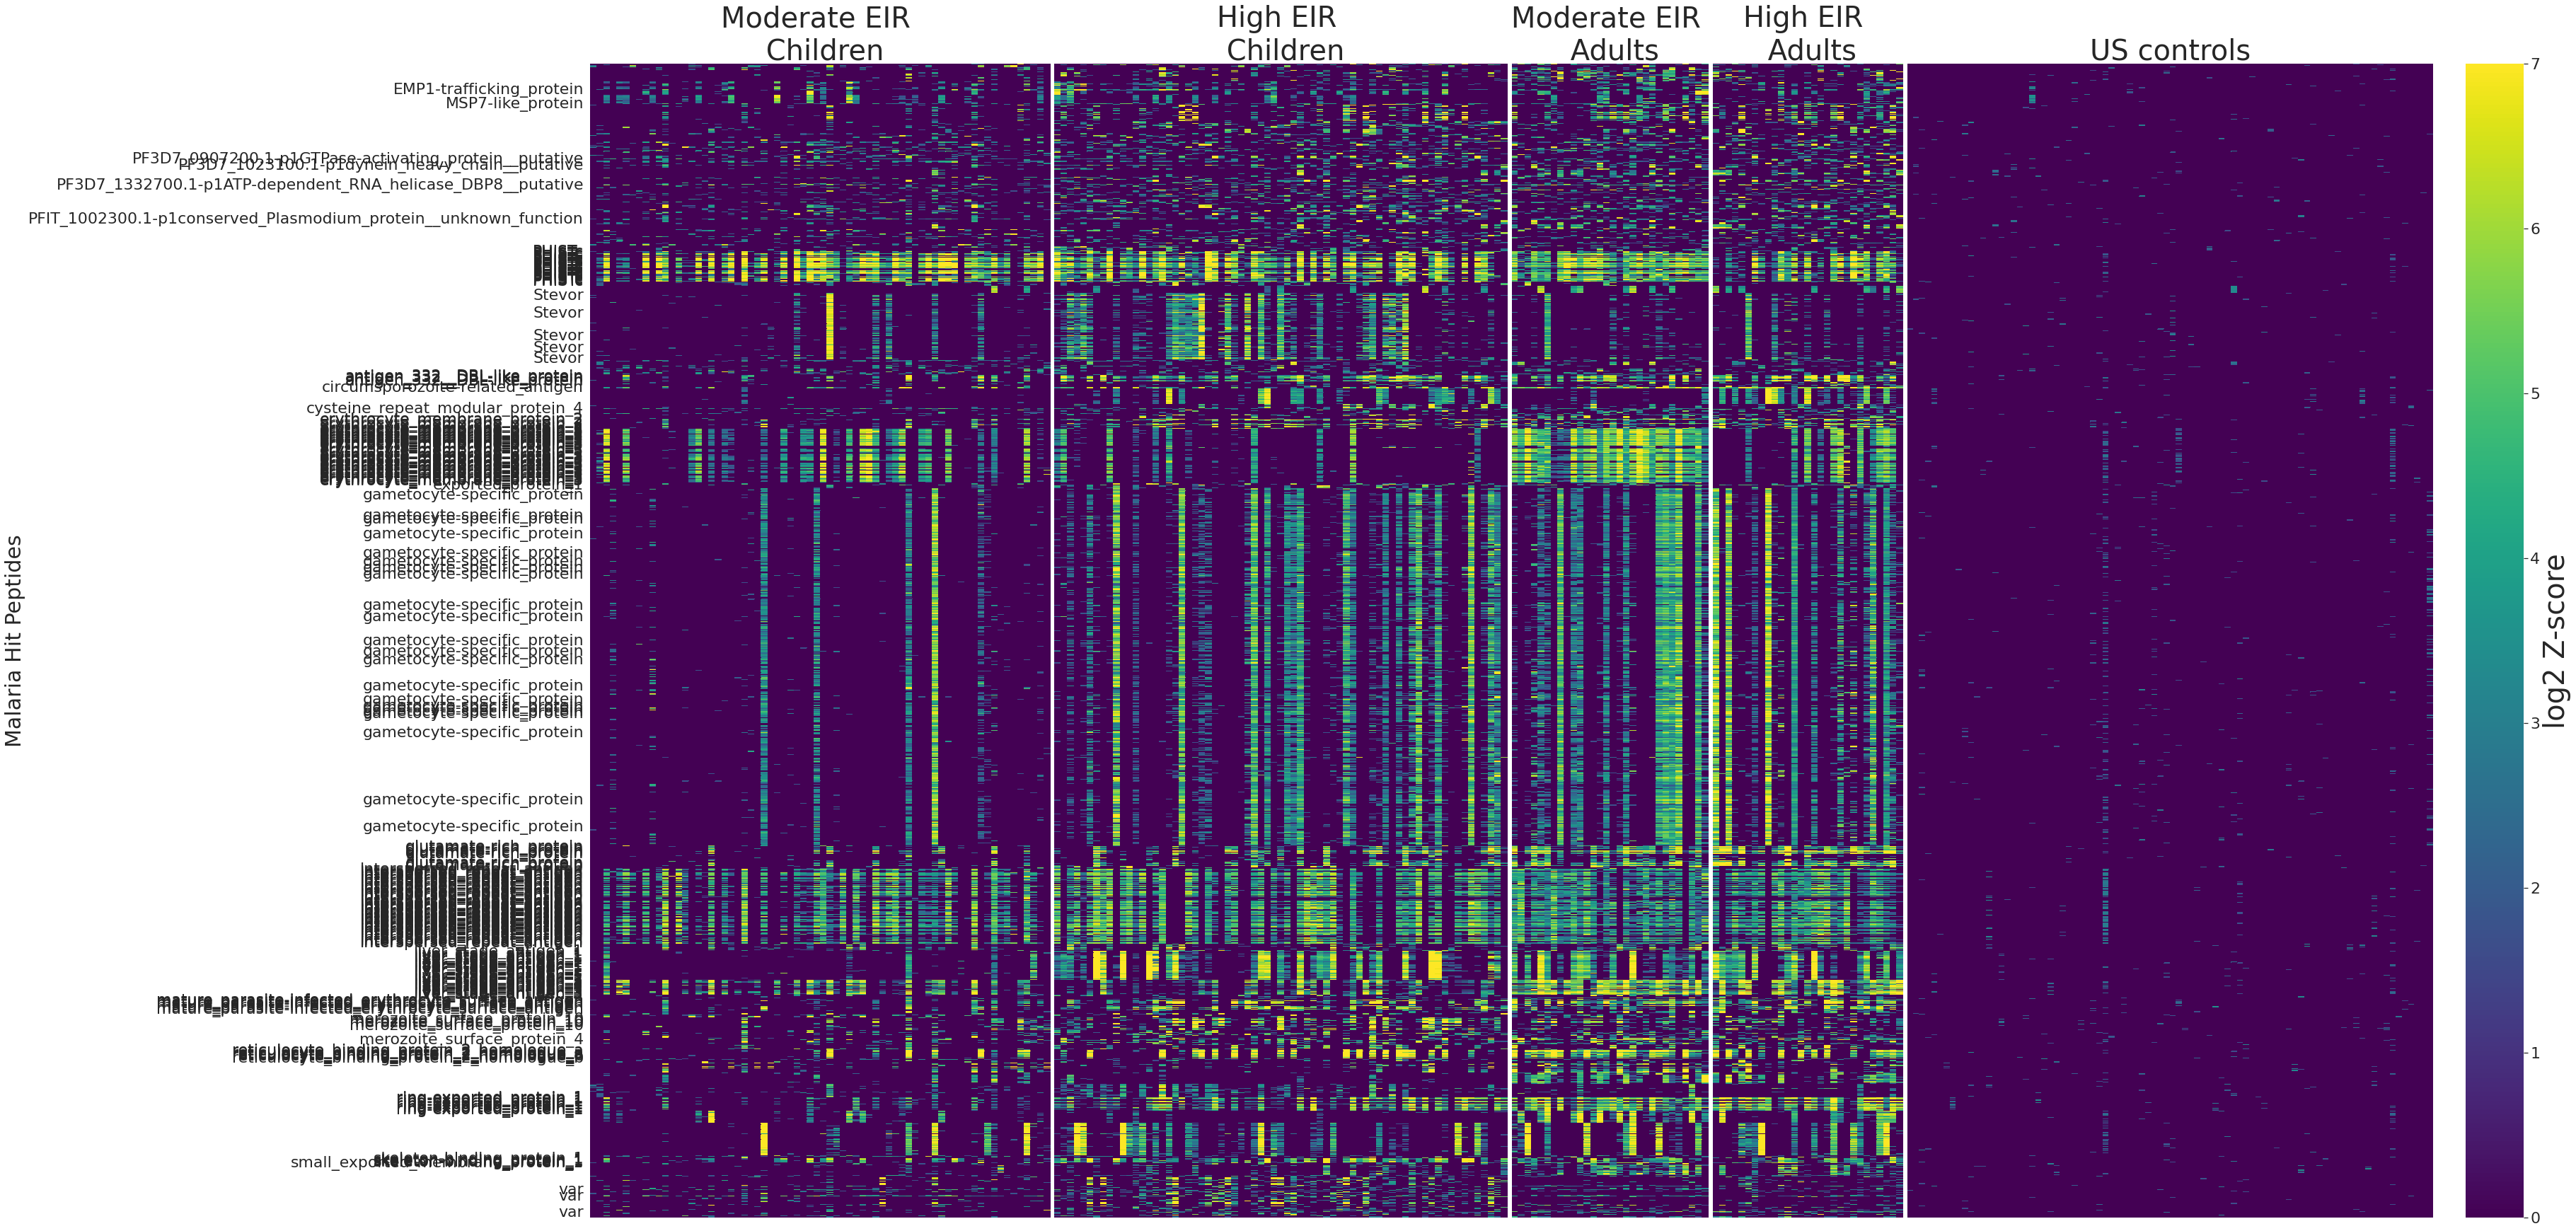

In [6]:
### plotting 1396 peeptides that are positive in >10% samples (>=20 people) 


from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=2)
ytick_labels = list(to_plot[seropositivity>=20]['immunogenic_product']) ### label only those with signal in >60 samples 
fig, (ax,ax2,ax3,ax4,ax5) = plt.subplots(ncols=5, gridspec_kw={'width_ratios': [70,69,30,29,100]},figsize = (50,30))
fig.subplots_adjust(wspace=0.01)
sns.heatmap(to_plot[seropositivity>=20].iloc[:,0:70],  ax=ax,  cmap = "viridis",cbar=False,vmin=0,vmax=7,xticklabels=False,yticklabels=ytick_labels,rasterized=True)
sns.heatmap(to_plot[seropositivity>=20].iloc[:,100:169],  ax=ax2,  cmap = "viridis",cbar=False,vmin=0,vmax=7,yticklabels=False,xticklabels=False,rasterized=True)
sns.heatmap(to_plot[seropositivity>=20].iloc[:,70:100],  ax=ax3, cmap = "viridis",cbar=False,vmin=0,vmax=7,yticklabels=False,xticklabels=False,rasterized=True)
sns.heatmap(to_plot[seropositivity>=20].iloc[:,169:198],  ax=ax4, cmap = "viridis", cbar=False,vmin=0,vmax=7,yticklabels=False,xticklabels=False,rasterized=True)
sns.heatmap(to_plot[seropositivity>=20].iloc[:,198:-2],  ax=ax5,  cmap = "viridis",vmin=0,vmax=7,xticklabels=False, yticklabels=False,rasterized=True)


ax.set_ylabel('Malaria Hit Peptides',size=30,fontname = 'sans-serif')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')
ax5.set_ylabel('')
ax.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax4.set_xlabel('')
ax5.set_xlabel('')

ax.set_title('Moderate EIR \n Children',size=40,fontname = 'sans-serif')
ax2.set_title('High EIR \n Children',size=40,fontname = 'sans-serif')
ax3.set_title('Moderate EIR \n Adults',size=40,fontname = 'sans-serif')
ax4.set_title('High EIR \n Adults',size=40,fontname = 'sans-serif')
ax5.set_title('US controls',size=40,fontname = 'sans-serif')

ax.figure.axes[-1].set_ylabel('log2 Z-score', size=40,fontname = 'sans-serif')

#plt.savefig('Fig2a_heatmap.pdf', dpi=400,bbox_inches='tight')



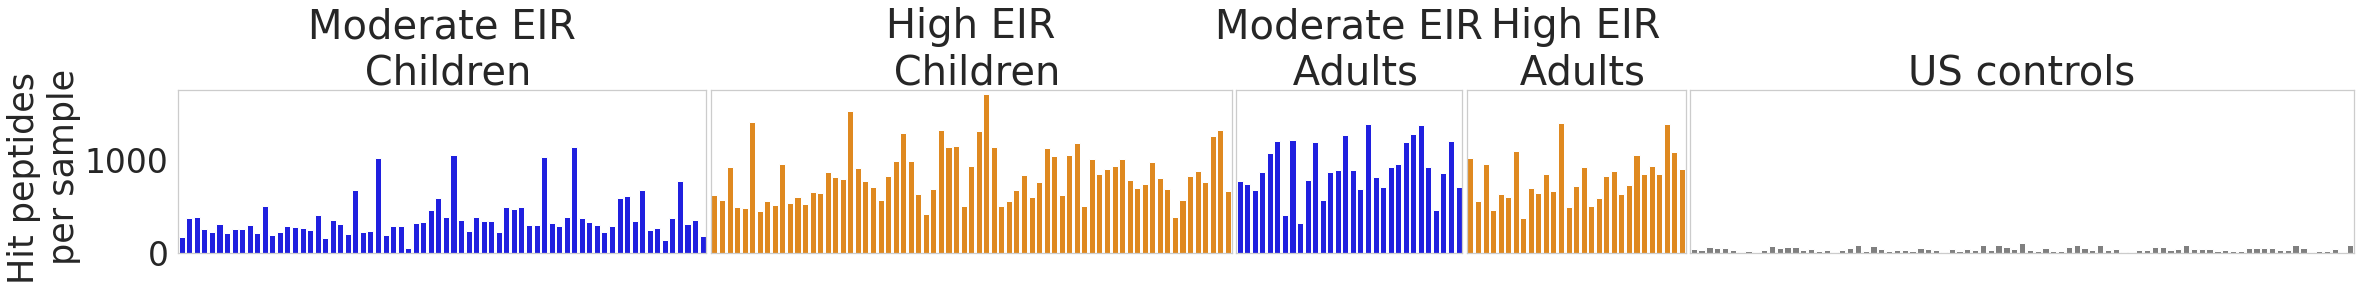

In [9]:
## Bar plot to place on top of the heat map 
from matplotlib import pyplot as plt
import seaborn as sns 
sns.set(font_scale=3)
sns.set_style("whitegrid", {'axes.grid' : False})
fig2, (ax,ax2,ax3,ax4,ax5) = plt.subplots(ncols=5, gridspec_kw={'width_ratios': [70,69,30,29,88]},figsize = (39,3))
fig2.subplots_adjust(wspace=0.01)
breadth = hits_5patients.sum(axis=1)
breadth_controls = hits_5.sum(axis=0).filter(regex='HC|hc')
breadth_controls.drop('HC041',inplace = True)
sns.barplot(x=list(breadth[0:70].index),y=breadth[0:70],ax=ax,color='blue')
sns.barplot(x=list(breadth[100:169].index),y=breadth[100:169],ax=ax2,color='darkorange')

sns.barplot(x=list(breadth[70:100].index),y=breadth[70:100],ax=ax3,color='blue')
sns.barplot(x=list(breadth[169:198].index),y=breadth[169:198],ax=ax4,color='darkorange')

sns.barplot(x=list(breadth_controls.index),y=breadth_controls,ax=ax5,color='grey')

ax.set_ylabel('Hit peptides \n per sample',size=35)
ax.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax4.set_xlabel('')
ax5.set_xlabel('')
ax.set(xlabel=None)
ax.set_ylim(0,1750)
ax2.set_ylim(0,1750)
ax3.set_ylim(0,1750)
ax4.set_ylim(0,1750)
ax5.set_ylim(0,1750)

ax2.axes.get_yaxis().set_visible(False)
ax3.axes.get_yaxis().set_visible(False)
ax4.axes.get_yaxis().set_visible(False)
ax5.axes.get_yaxis().set_visible(False)

ax.axes.get_xaxis().set_visible(False)
ax2.axes.get_xaxis().set_visible(False)
ax3.axes.get_xaxis().set_visible(False)
ax4.axes.get_xaxis().set_visible(False)
ax5.axes.get_xaxis().set_visible(False)



ax.set_title('Moderate EIR\n Children',size=40)
ax2.set_title('High EIR\n Children',size=40)
ax3.set_title('Moderate EIR\n Adults',size=40)
ax4.set_title('High EIR\n Adults',size=40)
ax5.set_title('US controls',size=40)



#plt.savefig('Fig2b_breadth_barplot.pdf', dpi=800,bbox_inches='tight')

plt.show()